In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,
    precision_recall_curve,
    confusion_matrix
)

# CHANGE THIS PATH:
DATA_DIR = "/kaggle/input/kepler-star-dataset-from-lightkurve/dataframes"
# For local:
# DATA_DIR = "/mnt/data"

files = sorted(glob.glob(os.path.join(DATA_DIR, "object*.csv")))
print(f"Found {len(files)} object*.csv files")
print("Example files:", files[:5])


Found 995 object*.csv files
Example files: ['/kaggle/input/kepler-star-dataset-from-lightkurve/dataframes/object1.csv', '/kaggle/input/kepler-star-dataset-from-lightkurve/dataframes/object10.csv', '/kaggle/input/kepler-star-dataset-from-lightkurve/dataframes/object100.csv', '/kaggle/input/kepler-star-dataset-from-lightkurve/dataframes/object1000.csv', '/kaggle/input/kepler-star-dataset-from-lightkurve/dataframes/object101.csv']


In [3]:
def pick_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    for cand in candidates:
        for c in df.columns:
            if cand.lower() in c.lower():
                return c
    return None

def to_float(series):
    return pd.to_numeric(series, errors="coerce").astype(float).values

def extract_features_from_csv(path, min_points=30):
    df = pd.read_csv(path)

    time_col = pick_col(df, ["time", "bkjd", "t"])
    flux_col = pick_col(df, ["flux", "pdcsap_flux", "sap_flux", "normalized_flux", "flux_norm"])
    ferr_col = pick_col(df, ["flux_err", "pdcsap_flux_err", "sap_flux_err", "flux_error", "fluxerr"])

    if flux_col is None:
        raise ValueError(f"No flux column in {path}")

    flux = to_float(df[flux_col])
    time = to_float(df[time_col]) if time_col else None

    m = np.isfinite(flux)
    if time is not None:
        m &= np.isfinite(time)

    flux = flux[m]
    if time is not None:
        time = time[m]

    n = len(flux)
    if n < min_points:
        return None

    eps = 1e-12
    F0 = float(np.median(flux))        # baseline
    std = float(np.std(flux, ddof=1))  # scatter

    Fmin = float(np.min(flux))
    Fmax = float(np.max(flux))

    # Robust scatter using MAD (recommended for significance)
    mad = float(np.median(np.abs(flux - F0)))
    sigma_rob = 1.4826 * mad + eps

    # Dimensionless features
    depth_ratio = float((F0 - Fmin) / (abs(F0) + eps))
    rms_ratio   = float(std / (abs(np.mean(flux)) + eps))
    ptp_ratio   = float((Fmax - Fmin) / (abs(F0) + eps))

    q10 = float(np.percentile(flux, 10))
    q90 = float(np.percentile(flux, 90))
    iqr_10_90_ratio = float((q90 - q10) / (abs(F0) + eps))

    # Dip fraction (2.5 sigma threshold using robust sigma)
    dip_thr = F0 - 2.5 * sigma_rob
    dip_fraction_2p5sigma = float(np.mean(flux < dip_thr))

    # Significance of deepest dip
    dip_significance = float((F0 - Fmin) / sigma_rob)

    # Time features
    if time is not None and len(time) > 2:
        ts = np.sort(time)
        time_span = float(ts[-1] - ts[0])
        cadence_median = float(np.median(np.diff(ts)))
    else:
        time_span = np.nan
        cadence_median = np.nan

    return {
        "depth_ratio": depth_ratio,
        "dip_significance": dip_significance,
        "dip_fraction_2p5sigma": dip_fraction_2p5sigma,
        "rms_ratio": rms_ratio,
        "ptp_ratio": ptp_ratio,
        "iqr_10_90_ratio": iqr_10_90_ratio,
        "time_span": time_span,
        "cadence_median": cadence_median,
        "n_points": int(n),
    }

In [4]:
rows, bad = [], []

for fp in files:
    obj_id = os.path.splitext(os.path.basename(fp))[0]
    try:
        feats = extract_features_from_csv(fp)
        if feats is None:
            continue
        feats["object_id"] = obj_id
        rows.append(feats)
    except Exception as e:
        bad.append((fp, str(e)))

feat_df = pd.DataFrame(rows).set_index("object_id").sort_index()

print("Feature table shape:", feat_df.shape)
print("Bad files:", len(bad))
feat_df.head()

Feature table shape: (995, 9)
Bad files: 0


,depth_ratio,dip_significance,dip_fraction_2p5sigma,rms_ratio,ptp_ratio,iqr_10_90_ratio,time_span,cadence_median,n_points
object_id,,,,,,,,,
object1,0.014195,71.433081,0.066098,0.001768,0.014876,0.000601,9.706267,0.020434,469
object10,0.000507,2.762987,0.006397,0.000161,0.000799,0.000420,9.706249,0.020434,469
object100,0.000188,3.154295,0.008529,0.000060,0.000414,0.000155,9.706386,0.020434,469
object1000,0.000885,2.643423,0.002132,0.000345,0.001819,0.000909,9.706296,0.020434,469
object101,0.002003,8.185173,0.043719,0.000333,0.003160,0.000646,33.471067,0.020434,1624


In [18]:
def make_labels(df, tau_min=0.005, tau_max=0.02, sig_thr=2.5):
    d = df["depth_ratio"]
    S = df["dip_significance"]
    y = ((S > sig_thr) & (d >= tau_min) & (d <= tau_max)).astype(int)
    return y

In [14]:
feature_sets = {
    "A_variability": ["rms_ratio", "ptp_ratio", "iqr_10_90_ratio"],
    "B_transitish": ["depth_ratio", "dip_significance", "dip_fraction_2p5sigma"],
    "C_all": ["depth_ratio", "dip_significance", "dip_fraction_2p5sigma",
              "rms_ratio", "ptp_ratio", "iqr_10_90_ratio", "n_points"]
}

# Vary the heuristic label bounds (tau range)
label_configs = [
    {"tau_min": 0.005, "tau_max": 0.02, "sig_thr": 2.5},
    {"tau_min": 0.003, "tau_max": 0.02, "sig_thr": 2.5},
    {"tau_min": 0.005, "tau_max": 0.03, "sig_thr": 2.5},
]

In [15]:
def safe_split(X, y, random_state=42):
    y = np.asarray(y)
    unique, counts = np.unique(y, return_counts=True)
    strat = y if (len(unique) == 2 and counts.min() >= 2) else None

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=random_state, stratify=strat
    )

    unique2, counts2 = np.unique(y_temp, return_counts=True)
    strat2 = y_temp if (len(unique2) == 2 and counts2.min() >= 2) else None

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=random_state, stratify=strat2
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
def eval_classifier(pipe, X_train, y_train, X_val, y_val, X_test, y_test):
    pipe.fit(X_train, y_train)

    def scores(X, y):
        proba = pipe.predict_proba(X)[:, 1]
        pred = (proba >= 0.5).astype(int)

        out = {
            "logloss": log_loss(y, proba, labels=[0,1]),
            "acc": accuracy_score(y, pred),
            "f1": f1_score(y, pred, zero_division=0),
        }
        if len(np.unique(y)) == 2:
            out["auc"] = roc_auc_score(y, proba)
        else:
            out["auc"] = np.nan
        return out, proba, pred

    tr, p_tr, yhat_tr = scores(X_train, y_train)
    va, p_va, yhat_va = scores(X_val, y_val)
    te, p_te, yhat_te = scores(X_test, y_test)

    return tr, va, te, (p_tr, p_va, p_te), (yhat_tr, yhat_va, yhat_te)

In [19]:
from sklearn.metrics import log_loss

In [20]:
Cs = [0.01, 0.1, 1, 10, 100]
clf_results = []

for lab in label_configs:
    y_all = make_labels(feat_df, **lab)

    for fs_name, cols in feature_sets.items():
        df_use = feat_df[cols].copy()
        df_use["y"] = y_all
        df_use = df_use.dropna()

        if df_use["y"].nunique() < 2 or len(df_use) < 50:
            continue

        X = df_use[cols].values
        y = df_use["y"].values

        X_train, X_val, X_test, y_train, y_val, y_test = safe_split(X, y)

        for C in Cs:
            # L2 logistic
            pipe_l2 = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", LogisticRegression(penalty="l2", C=C, solver="lbfgs", max_iter=4000))
            ])
            tr, va, te, _, _ = eval_classifier(pipe_l2, X_train, y_train, X_val, y_val, X_test, y_test)
            clf_results.append({"label": str(lab), "fs": fs_name, "model": "LogReg_L2", "C": C,
                                "tr_logloss": tr["logloss"], "va_logloss": va["logloss"], "te_logloss": te["logloss"],
                                "va_auc": va["auc"], "te_auc": te["auc"], "va_f1": va["f1"], "te_f1": te["f1"]})

            # L1 logistic
            pipe_l1 = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", LogisticRegression(penalty="l1", C=C, solver="liblinear", max_iter=4000))
            ])
            tr, va, te, _, _ = eval_classifier(pipe_l1, X_train, y_train, X_val, y_val, X_test, y_test)
            clf_results.append({"label": str(lab), "fs": fs_name, "model": "LogReg_L1", "C": C,
                                "tr_logloss": tr["logloss"], "va_logloss": va["logloss"], "te_logloss": te["logloss"],
                                "va_auc": va["auc"], "te_auc": te["auc"], "va_f1": va["f1"], "te_f1": te["f1"]})

clf_df = pd.DataFrame(clf_results)
clf_df.sort_values(["va_auc", "va_f1"], ascending=False).head(15)

,label,fs,model,C,tr_logloss,va_logloss,te_logloss,va_auc,te_auc,va_f1,te_f1
20,"{'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...",C_all,LogReg_L2,0.01,0.284293,0.286635,0.295191,0.896617,0.868004,0.117647,0.000000
22,"{'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...",C_all,LogReg_L2,0.10,0.262338,0.262104,0.280374,0.886748,0.867537,0.111111,0.210526
89,"{'tau_min': 0.005, 'tau_max': 0.03, 'sig_thr':...",C_all,LogReg_L1,100.00,0.273583,0.289438,0.302390,0.884648,0.887505,0.240000,0.370370
88,"{'tau_min': 0.005, 'tau_max': 0.03, 'sig_thr':...",C_all,LogReg_L2,100.00,0.273587,0.289742,0.302100,0.884224,0.887103,0.240000,0.370370
23,"{'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...",C_all,LogReg_L1,0.10,0.268606,0.271379,0.285240,0.878994,0.846549,0.111111,0.111111
87,"{'tau_min': 0.005, 'tau_max': 0.03, 'sig_thr':...",C_all,LogReg_L1,10.00,0.273703,0.292220,0.300478,0.877439,0.885496,0.240000,0.428571
28,"{'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...",C_all,LogReg_L2,100.00,0.258372,0.253147,0.286693,0.876410,0.862873,0.285714,0.190476
29,"{'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...",C_all,LogReg_L1,100.00,0.258370,0.252858,0.286720,0.876410,0.862873,0.285714,0.190476
25,"{'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...",C_all,LogReg_L1,1.00,0.259891,0.259066,0.282432,0.875940,0.864739,0.200000,0.200000
27,"{'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...",C_all,LogReg_L1,10.00,0.258474,0.255135,0.285634,0.875470,0.860541,0.285714,0.190476


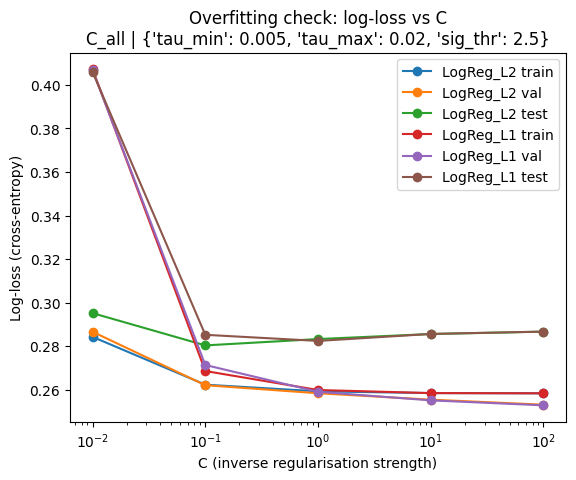

In [21]:
def plot_overfitting_curve(df, label_str, fs_name):
    sub = df[(df["label"] == label_str) & (df["fs"] == fs_name)]
    if sub.empty:
        print("No results for", label_str, fs_name)
        return

    plt.figure()
    for model in sub["model"].unique():
        s = sub[sub["model"] == model].sort_values("C")
        plt.plot(s["C"], s["tr_logloss"], marker="o", label=f"{model} train")
        plt.plot(s["C"], s["va_logloss"], marker="o", label=f"{model} val")
        plt.plot(s["C"], s["te_logloss"], marker="o", label=f"{model} test")

    plt.xscale("log")
    plt.xlabel("C (inverse regularisation strength)")
    plt.ylabel("Log-loss (cross-entropy)")
    plt.title(f"Overfitting check: log-loss vs C\n{fs_name} | {label_str}")
    plt.legend()
    plt.show()


example_label = str(label_configs[0])
example_fs = "C_all"
plot_overfitting_curve(clf_df, example_label, example_fs)

In [22]:
def make_transit_score(df, tau_max=0.02):
    d = df["depth_ratio"].clip(lower=0)
    S = df["dip_significance"].clip(lower=0)

    d_term = np.minimum(1.0, d / tau_max)
    S_term = np.minimum(1.0, S / 5.0)   # 5-sigma saturates

    score = d_term * S_term
    return score

In [32]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [33]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

reg_results = []

# pick one label config's tau_max for score scaling (or loop)
tau_max_for_score = 0.02
score_all = make_transit_score(feat_df, tau_max=tau_max_for_score)

for fs_name, cols in feature_sets.items():
    df_use = feat_df[cols].copy()
    df_use["score"] = score_all
    df_use = df_use.dropna()

    if len(df_use) < 50:
        continue

    X = df_use[cols].values
    y = df_use["score"].values

    # regression split 
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

    for a in alphas:
        # Ridge
        ridge = Pipeline([("scaler", StandardScaler()), ("reg", Ridge(alpha=a))])
        ridge.fit(X_train, y_train)

        tr_mse = mean_squared_error(y_train, ridge.predict(X_train))
        va_mse = mean_squared_error(y_val, ridge.predict(X_val))
        te_mse = mean_squared_error(y_test, ridge.predict(X_test))

        reg_results.append({"fs": fs_name, "model": "Ridge", "alpha": a,
                            "tr_mse": tr_mse, "va_mse": va_mse, "te_mse": te_mse})

        # Lasso
        lasso = Pipeline([("scaler", StandardScaler()), ("reg", Lasso(alpha=a, max_iter=20000))])
        lasso.fit(X_train, y_train)

        tr_mse = mean_squared_error(y_train, lasso.predict(X_train))
        va_mse = mean_squared_error(y_val, lasso.predict(X_val))
        te_mse = mean_squared_error(y_test, lasso.predict(X_test))

        reg_results.append({"fs": fs_name, "model": "Lasso", "alpha": a,
                            "tr_mse": tr_mse, "va_mse": va_mse, "te_mse": te_mse})

reg_df = pd.DataFrame(reg_results)
reg_df.sort_values("va_mse").head(10)

,fs,model,alpha,tr_mse,va_mse,te_mse
27,C_all,Lasso,0.0010,0.010536,0.009071,1.164758
34,C_all,Ridge,10.0000,0.010460,0.009121,1.133458
32,C_all,Ridge,1.0000,0.010227,0.009334,1.063676
25,C_all,Lasso,0.0001,0.010189,0.009524,1.030201
30,C_all,Ridge,0.1000,0.010180,0.009630,1.014040
28,C_all,Ridge,0.0100,0.010179,0.009682,1.006740
26,C_all,Ridge,0.0010,0.010179,0.009688,1.005977
24,C_all,Ridge,0.0001,0.010179,0.009688,1.005900
29,C_all,Lasso,0.0100,0.010846,0.010495,0.991108
12,B_transitish,Ridge,0.0001,0.011202,0.010737,1.201231


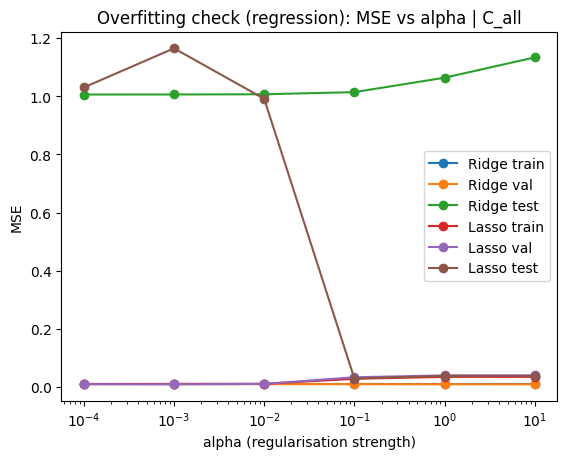

In [34]:
def plot_reg_overfitting(df, fs_name):
    sub = df[df["fs"] == fs_name]
    if sub.empty:
        print("No regression results for", fs_name)
        return

    plt.figure()
    for model in sub["model"].unique():
        s = sub[sub["model"] == model].sort_values("alpha")
        plt.plot(s["alpha"], s["tr_mse"], marker="o", label=f"{model} train")
        plt.plot(s["alpha"], s["va_mse"], marker="o", label=f"{model} val")
        plt.plot(s["alpha"], s["te_mse"], marker="o", label=f"{model} test")

    plt.xscale("log")
    plt.xlabel("alpha (regularisation strength)")
    plt.ylabel("MSE")
    plt.title(f"Overfitting check (regression): MSE vs alpha | {fs_name}")
    plt.legend()
    plt.show()

plot_reg_overfitting(reg_df, "C_all")

In [35]:
best = clf_df.sort_values(["va_auc", "va_f1"], ascending=False).iloc[0]
best

label         {'tau_min': 0.005, 'tau_max': 0.02, 'sig_thr':...
fs                                                        C_all
model                                                 LogReg_L2
C                                                          0.01
tr_logloss                                             0.284293
va_logloss                                             0.286635
te_logloss                                             0.295191
va_auc                                                 0.896617
te_auc                                                 0.868004
va_f1                                                  0.117647
te_f1                                                       0.0
Name: 20, dtype: object

Validation: {'logloss': 0.28663473612799756, 'acc': 0.8993288590604027, 'f1': 0.11764705882352941, 'auc': np.float64(0.8966165413533834)}
Test: {'logloss': 0.29519114700209326, 'acc': 0.8866666666666667, 'f1': 0.0, 'auc': np.float64(0.8680037313432836)}


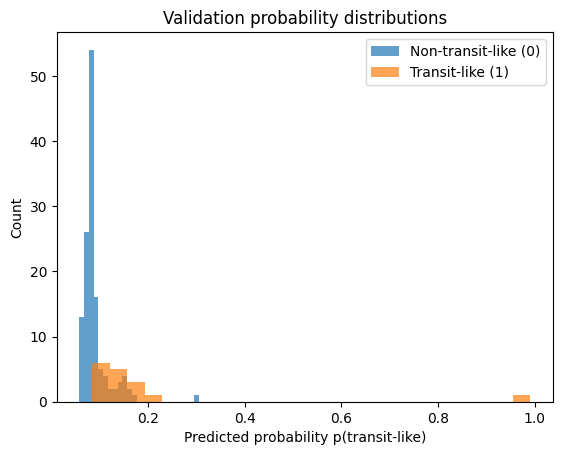

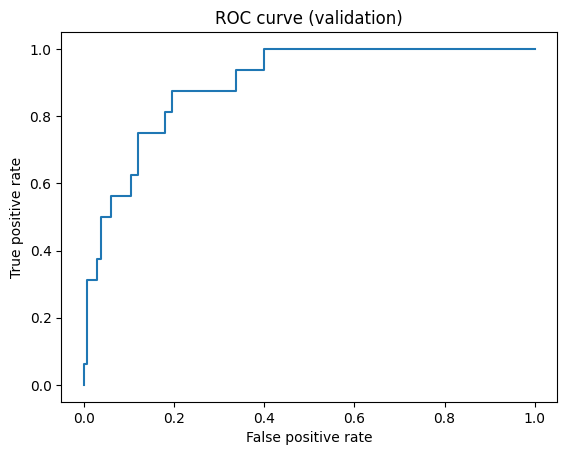

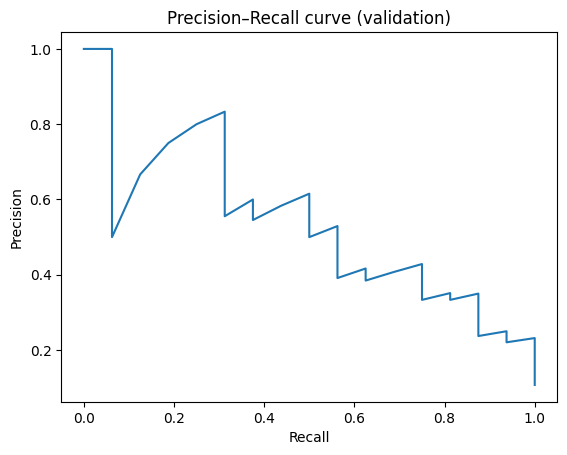

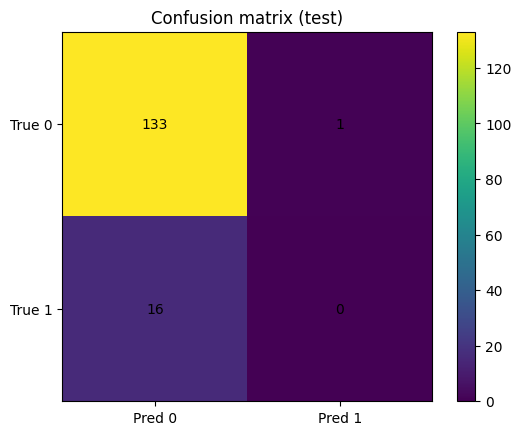

In [36]:
# Re-train best model and plot probability distributions + ROC/PR
lab = eval(best["label"])  # convert string back to dict
fs_name = best["fs"]
C = best["C"]
model = best["model"]

cols = feature_sets[fs_name]
df_use = feat_df[cols].dropna()

y = make_labels(feat_df.loc[df_use.index], **lab).values
X = df_use.values

X_train, X_val, X_test, y_train, y_val, y_test = safe_split(X, y)

if model == "LogReg_L2":
    pipe = Pipeline([("scaler", StandardScaler()),
                     ("clf", LogisticRegression(penalty="l2", C=C, solver="lbfgs", max_iter=4000))])
else:
    pipe = Pipeline([("scaler", StandardScaler()),
                     ("clf", LogisticRegression(penalty="l1", C=C, solver="liblinear", max_iter=4000))])

tr, va, te, probs, preds = eval_classifier(pipe, X_train, y_train, X_val, y_val, X_test, y_test)
p_tr, p_va, p_te = probs

print("Validation:", va)
print("Test:", te)

# Probability histogram (validation)
plt.figure()
plt.hist(p_va[y_val==0], bins=25, alpha=0.7, label="Non-transit-like (0)")
plt.hist(p_va[y_val==1], bins=25, alpha=0.7, label="Transit-like (1)")
plt.xlabel("Predicted probability p(transit-like)")
plt.ylabel("Count")
plt.title("Validation probability distributions")
plt.legend()
plt.show()

# ROC curve
if len(np.unique(y_val)) == 2:
    fpr, tpr, _ = roc_curve(y_val, p_va)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve (validation)")
    plt.show()

# PR curve
if len(np.unique(y_val)) == 2:
    prec, rec, _ = precision_recall_curve(y_val, p_va)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall curve (validation)")
    plt.show()

# Confusion matrix (test)
p_test = pipe.predict_proba(X_test)[:,1]
yhat_test = (p_test >= 0.5).astype(int)
cm = confusion_matrix(y_test, yhat_test)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix (test)")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.colorbar()
plt.show()